Notebook to create a regional rainfall-runoff model using a LSTM network

In [1]:
#Import necessary packages
import os
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [2]:
# identify and define GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')

1
NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [3]:
# colorblind friendly color palet
color_dictionary = {
    "Observed": "#7b85d4",
    "LSTM": "#e9d043",
    "LSTM+SHM": "#83c995",
    "LSTM+Bucket": "#859795",
    "LSTM+NonSense": "#ad5b50",
    "SHM": "#f37738"}

Part 1. Create classes and functions

In [4]:
class SequenceDataset(Dataset):
    """
    This class will allow us to create a custom DataSet to handle time series of a basin. 

    Objective:
    The major objective of the class is to create two tensors.
    1) The first tensor will be a 2D tensor that contains the information of a specific basin. The rows are the time 
    (one row per day) and the columns will be features (forcing variables and static attributes).
    2) The second tensor will have the same structure as the one described before, but it just have one column, that is
    associated with the target variable.
    """
    # Create the 2D tensors
    def __init__(self,
                 gauges_id,  # ID of basin [int]
                 forcing,  # name of the dynamic forcings [list]
                 target,  # name of the target [list]
                 attributes,  # name of the static attributes [list]
                 sequence_length,  # sequence length in days for the lstm [int]
                 dataset_type, # 'training' or 'testing' [string]
                 training_period,  # start and end day of training period [list]
                 testing_period,  # start and end day of testing period [list]
                 path_ts,  # path to time series [string]
                 path_climatic_attributes,  # path to climatic attributes[string]
                 path_hydrologic_attributes,  # path to hydrologic attributes [string]
                 path_topographic_attributes,  # path to topographic attributes [string]
                 path_landcover_attributes,  # path to landcover attributes [string]
                 path_soil_attributes,  # path to landcover attributes [string]
                 ):

        # read variables and store them in self
        self.catch_id = gauges_id  # catchment ID
        self.forcing = forcing  # dynamic attributes
        self.target = target  # target
        self.attributes = attributes  # static attributes
        self.sequence_length = sequence_length  # sequence length

        self.dataset_type = dataset_type # training or testing
        self.training_period = training_period #training period
        self.testing_period = testing_period # validation or testing period

        self.path_climatic_attributes = path_climatic_attributes
        self.path_hydrologic_attributes = path_hydrologic_attributes
        self.path_topographic_attributes = path_topographic_attributes
        self.path_landcover_attributes = path_landcover_attributes
        self.path_soil_attributes = path_soil_attributes

        # load time series
        path_timeseries = path_ts + 'CAMELS_GB_hydromet_timeseries_' + str(self.catch_id) + '.csv'
        df_ts = pd.read_csv(path_timeseries)

        # dynamic forcings
        df_forcing = df_ts.loc[:, self.forcing]
        df_forcing = df_forcing.set_index('date')

        # target variable
        df_target = df_ts.loc[:, self.target]
        df_target = df_target.set_index('date')
        
        if self.dataset_type=='training':
            # training period subset
            df_forcing = df_forcing.loc[self.training_period[0]:self.training_period[1]]
            df_target = df_target.loc[self.training_period[0]:self.training_period[1]]
            # used later for Basin-averaged-NSE (just for training!)
            self.basin_target_std = torch.tensor(df_target.std(), dtype=float)
        else:
            df_forcing = df_forcing.loc[self.testing_period[0]:self.testing_period[1]]
            df_target = df_target.loc[self.testing_period[0]:self.testing_period[1]]
    
        # load the attributes
        self.df_attributes = self.process_attributes()    
        # repeat the static attributes to the length of the timeseries
        ob_df_attri = pd.DataFrame(np.repeat(self.df_attributes.values, len(df_forcing), axis=0))
        ob_df_attri.columns = self.df_attributes.columns
        ob_df_attri.index = df_forcing.index

        # join dynamic forcings and static attributes
        df_all = df_forcing.join(ob_df_attri)

        # select features (X) and target (y)
        self.X = torch.tensor(df_all.values, dtype=torch.float)
        self.y = torch.tensor(df_target.values, dtype=torch.float)

        # target and feature minus the chosen sequence length
        self.X_out = torch.tensor(df_all.values[(self.sequence_length - 1):len(self.y)], dtype=torch.float)
        self.y_out = torch.tensor(df_target.values[(self.sequence_length - 1):len(self.y)], dtype=torch.float)


    def __len__(self):
        # Function to define length of data (same as length of my time series)
        return self.X_out.shape[0]

    def __getitem__(self, i):
        # Function to extract the necessary information during training, validation and testing
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X_out[i_start:(i + 1), :]
        else:
            padding = self.X[(i):(self.sequence_length-1),:]
            x = self.X_out[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
            
        if self.dataset_type =='training':
            return x, self.y_out[i], self.basin_target_std
        else:
            return x, self.y_out[i]


    def process_attributes(self):
        # Function to process the attributes and return the ones we are interested in
        df_climatic_attributes = pd.read_csv(self.path_climatic_attributes).set_index('gauge_id')
        df_hydrologic_attributes = pd.read_csv(self.path_hydrologic_attributes).set_index('gauge_id')
        df_topographic_attributes = pd.read_csv(self.path_topographic_attributes).set_index('gauge_id')
        df_landcover_attributes = pd.read_csv(self.path_landcover_attributes).set_index('gauge_id')
        df_soil_attributes = pd.read_csv(self.path_soil_attributes).set_index('gauge_id')
        # join attributes
        df_attributes = (((df_climatic_attributes.join(
            df_hydrologic_attributes)).join(
            df_topographic_attributes)).join(
            df_landcover_attributes)).join(
            df_soil_attributes)
        # filter attributes by catchment
        df_attributes = df_attributes[df_attributes.index == self.catch_id]
        # filter attributes by name
        df_attributes = df_attributes[self.attributes]

        return df_attributes

    def standardize_features(self, global_feature_mean, global_feature_std):
        # standardize features using global mean and std
        self.X = (self.X - global_feature_mean) / global_feature_std
        self.X_out = (self.X_out - global_feature_mean) / global_feature_std

    def standardize_target(self, global_target_mean, global_target_std):
        # standardze target using global mean and std
        self.y = (self.y - global_target_mean) / global_target_std
        self.y_out = (self.y_out - global_target_mean) / global_target_std

In [5]:
# Loss function used in training
def NSE_BasinAveraged(pred, obs, per_basin_target_stds):
    """
    Function to calculate the basin-averaged-NSE proposed by (Kratzert, et al. 2019). I weight my squared error by the
    std of the discharges of the specific basin, to avoid calibrating only for basins with high discharge.

    :pred: tensor with simulated discharges
    :obs: tensor with observed discharges
    :per_basin_target_stds:  tensor with standard deviation of the discharges of the basins that is associated
    with the pred.

    Equation 13 in https://doi.org/10.5194/hess-23-5089-2019
    """
    squared_error = (pred - obs)**2
    weights = 1 / (per_basin_target_stds + 0.1)**2
    loss = torch.mean(weights * squared_error)
    return loss

In [6]:
# NSE function, used in validation and testing
def nse_loss(pred, obs):
    loss = torch.empty(size=(1, len(pred)), dtype=torch.float32)
    # Calculate loss
    for i, pred in enumerate(pred):
        loss[0,i] = 1.0 - torch.sum((pred - obs[i])**2) / torch.sum((obs[i] - torch.mean(obs[i]))**2)
        
    return loss

In [7]:
# fix random seeds for various packages
def set_random_seeds(seed=None):
    if seed is None:
        seed = int(np.random.uniform(low=0, high=1e6))

    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

In [8]:
# Function to write the progress report
def write_progress(file_name, text):
    if os.path.exists(file_name):
        append_write = 'a' # append if already exists   
    else:
        append_write = 'w' # make a new file if not

    highscore = open(file_name , append_write)
    highscore.write(text + '\n')
    highscore.close()

Part 2. Initialize information

In [9]:
# paths to access the information
path_basins= '../data/CAMELS-GB/timeseries_v2/Selected_Basins.csv'
path_ts = '../data/CAMELS-GB/timeseries_v2/'
path_climatic_attributes = '../data/CAMELS-GB/CAMELS_GB_climatic_attributes.csv'
path_hydrologic_attributes = '../data/CAMELS-GB/CAMELS_GB_hydrologic_attributes.csv'
path_topographic_attributes = '../data/CAMELS-GB/CAMELS_GB_topographic_attributes.csv'
path_landcover_attributes = '../data/CAMELS-GB/CAMELS_GB_landcover_attributes.csv'
path_soil_attributes = '../data/CAMELS-GB/CAMELS_GB_soil_attributes.csv'

# dynamic forcings and target (ALWAYS INCLUDE THE DATE AS FIRST ARGUMENT)
forcing=['date','precipitation', 'peti', 'temperature']
target=['date', 'discharge_spec']

# static attributes that will be used
attributes = ['p_mean',
              'pet_mean',
              'aridity',
              'frac_snow',
              'high_prec_freq',
              'high_prec_dur',
              'low_prec_freq',
              'low_prec_dur',
              'q_mean',
              'runoff_ratio',
              'baseflow_index',
              'area',
              'dpsbar',
              'elev_mean',
              'urban_perc',
              'crop_perc',
              'inwater_perc',
              'sand_perc',
              'silt_perc',
              'clay_perc']

# time periods
training_period = ['1987-10-01','1999-09-30']
validation_period = ['1999-10-01','2004-09-30']
testing_period = ['2006-04-05','2012-09-30']

network_params = {
  "input_size": len(attributes)+3,
  "no_of_layers":1,  
  "sequence_length": 180,
  "hidden_size": 64, # set hidden_size of model
  "batch_size":256,
  "no_of_epochs": 10, # number of training epochs            
  "drop_out": 0.4, # set drop_out of model
  "learning_rate": 0.001,
  "adapt_learning_rate_epoch": 5,
  "adapt_gamma_learning_rate": 0.8,
  'set_forget_gate':3,
}

# define seed
random_seed = 42
set_random_seeds(seed=random_seed)

# Name of the folder where the results will be stored 
save_folder = '../results/models/LSTM'

In [ ]:
# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(save_folder):
    # Create the folder
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' created successfully.")
else:
    print(f"Folder '{save_folder}' already exists.")

Part 3. Create DataSet containing the information of all the basins

In [10]:
# Dataset training
# Create a dataset for each basin and store all of them in a list
selected_basins_id= list(np.loadtxt(path_basins, skiprows=1).astype(int))
training_datasets = []
for basin in selected_basins_id:
    training_datasets.append(SequenceDataset(gauges_id = basin,
                                             forcing = forcing,
                                             target = target,
                                             attributes = attributes, 
                                             sequence_length = network_params['sequence_length'], 
                                             dataset_type='training',
                                             training_period = training_period,
                                             testing_period = testing_period,
                                             path_ts = path_ts, 
                                             path_climatic_attributes = path_climatic_attributes, 
                                             path_hydrologic_attributes = path_hydrologic_attributes, 
                                             path_topographic_attributes = path_topographic_attributes, 
                                             path_landcover_attributes = path_landcover_attributes,
                                             path_soil_attributes = path_soil_attributes))

# Make a tensor that have the information (features for aux1 and target for aux2) of all the basins
aux1 = torch.cat([dataset.X for dataset in training_datasets], dim=0)
aux2 = torch.cat([dataset.y for dataset in training_datasets], dim=0)
# Calculate global mean and std for features and targets
global_feature_mean = torch.mean(aux1, dim=0)
global_feature_std = torch.std(aux1, dim=0)
global_target_mean = torch.mean(aux2, dim=0)
global_target_std = torch.std(aux2, dim=0)
# Delete aux1 and aux2 (tensors are quite big)
del aux1, aux2

# the xx_perc attributes are percentages, and they have meaning by their own and not just when compared to other 
# basins, so the standarization is different. This part is hard-coded as the position of this attributes may
# vary. It is also not a standard practice, so this can be ommited.
global_feature_mean[-6:]=torch.tensor(0.0)
global_feature_std[-6:]=torch.tensor(100.0)

# Standarize features and targets
for dataset in training_datasets:
    dataset.standardize_features(global_feature_mean=global_feature_mean,
                                 global_feature_std= global_feature_std)
    
    dataset.standardize_target(global_target_mean=global_target_mean,
                               global_target_std= global_target_std)

# Concatenate all the datasets so the DataLoader can access all the basins and the same time
training_datasets_concat = torch.utils.data.ConcatDataset(training_datasets)   

In [11]:
# Dataset validation
#Create a dataset for each basin and store all of them in a list
validation_datasets = []
for basin in selected_basins_id:
    validation_datasets.append(SequenceDataset(gauges_id = basin,
                                               forcing = forcing,
                                               target = target,
                                               attributes = attributes, 
                                               sequence_length = network_params['sequence_length'], 
                                               dataset_type='testing',
                                               training_period = training_period,
                                               testing_period = validation_period,
                                               path_ts = path_ts, 
                                               path_climatic_attributes = path_climatic_attributes, 
                                               path_hydrologic_attributes = path_hydrologic_attributes, 
                                               path_topographic_attributes = path_topographic_attributes, 
                                               path_landcover_attributes = path_landcover_attributes,
                                               path_soil_attributes = path_soil_attributes))

# For testing, we just have to standarize the features, and they are standarized with the global mean and std of the
# TRAINING period
for dataset in validation_datasets:
    dataset.standardize_features(global_feature_mean=global_feature_mean,
                                 global_feature_std= global_feature_std)

# Concatenate all the datasets so the DataLoader can access all the basins and the same time
validation_datasets_concat = torch.utils.data.ConcatDataset(validation_datasets) 

Part 4. Create DataLoaders

In [12]:
#Dataloader training
train_loader = DataLoader(dataset=training_datasets_concat,
                          batch_size=network_params['batch_size'],
                          shuffle=True,
                          drop_last=True)

# See if the batches are loaded correctly
print('Batches in training: ', len(train_loader))
X, y, std = next(iter(train_loader))
print(f'Batch features shape: {X.shape} | Batch target shape: {y.shape} | Batch basin std shape: {std.shape}')

Batches in training:  6355
Batch features shape: torch.Size([256, 180, 23]) | Batch target shape: torch.Size([256, 1]) | Batch basin std shape: torch.Size([256, 1])


In [13]:
#Dataloader validation
# Create batches to extract all the elements of each basin (one batch per basin)
size_datasets = [len(dataset) for dataset in validation_datasets]
validation_batches=[list(range(sum(size_datasets[:i]), sum(size_datasets[:i+1]))) for i in range(len(size_datasets))]

validation_loader = DataLoader(dataset=validation_datasets_concat,
                          batch_sampler=validation_batches)

# See if the batches are loaded correctly
print('Batches in training: ', len(validation_loader))
X, y = next(iter(validation_loader))
print(f'Batch features shape: {X.shape} | Batch target shape: {y.shape}')

Batches in training:  387
Batch features shape: torch.Size([1648, 180, 23]) | Batch target shape: torch.Size([1648, 1])


Part 5. Create LSTM

In [14]:
class RNN_network(nn.Module):
    def __init__(self, network_params, cuda):
        super().__init__()
        self.num_features = network_params['input_size']
        self.hidden_units = network_params['hidden_size']
        self.num_layers = network_params['no_of_layers']
        self.cuda0 = cuda

        self.lstm = nn.LSTM(input_size = network_params['input_size'], 
                            hidden_size = network_params['hidden_size'], 
                            batch_first = True,
                            num_layers = network_params['no_of_layers'])

        
        self.dropout = torch.nn.Dropout(network_params['drop_out'])
        self.linear = nn.Linear(in_features=network_params['hidden_size'], out_features=1)
           
    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.cuda0)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.cuda0)
        
        out, (hn_1, cn_1) = self.lstm(x, (h0, c0))
        out = out[:,-1,:]       # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)  # first dim of Hn is num_layers, which is set to 1 above.

        return out, hn_1.transpose(0,1), cn_1.transpose(0,1)

In [15]:
# construct model
network = RNN_network(network_params, cuda0).to(cuda0)

Part 6. Train LSTM

In [ ]:
# optimizer
optimizer = torch.optim.Adam(network.parameters(),
                             lr = network_params["learning_rate"], 
                             weight_decay=0.00001)
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = network_params["adapt_learning_rate_epoch"],
                                            gamma = network_params["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
network.lstm.bias_hh_l0.data[network_params['hidden_size']:2 * network_params['hidden_size']] = network_params["set_forget_gate"]

training_time = time.time()
for epoch in range(network_params["no_of_epochs"]):
    
    epoch_start_time = time.time()
    total_loss = 0
    # Training ----------------------------------------------------------------------
    network.train()
    for (X, y, per_basin_target_stds) in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        y_pred, _ , _  = network(X.to(cuda0)) # forward call
        loss = NSE_BasinAveraged(pred=y_pred, 
                                 obs=y.to(cuda0), 
                                 per_basin_target_stds=per_basin_target_stds.to(cuda0))
        
        loss.backward() # backpropagates
        optimizer.step() #update weights
        total_loss += loss.item()
        
        # remove from cuda
        del X, y, y_pred, per_basin_target_stds
        torch.cuda.empty_cache()
        
    #average loss training    
    average_loss_training = total_loss / len(train_loader)
    
    # Validation ----------------------------------------------------------------------
    network.eval()
    sim_q_testing = []
    obs_q_testing = []
    with torch.no_grad():
        for (X, y) in validation_loader: 
            # Run LSTM
            y_pred, _ , _  = network(X.to(cuda0)) # forward call
            #Bring back to cpu
            q_sim=y_pred.flatten().cpu().detach()
            # Rescale using the global mean and std of the training period
            sim_q_testing.append(q_sim*global_target_std+global_target_mean)
            # Read observed value
            obs_q_testing.append(y.flatten().cpu().detach())

            # remove from cuda
            del X, y, y_pred
            torch.cuda.empty_cache()       
            
        #average loss validation
        loss_validation = nse_loss(pred=sim_q_testing, obs=obs_q_testing)
        average_loss_validation = torch.mean(loss_validation)
    
    
    # Save model after every epoch
    path_saved_model = save_folder+'/epoch_' + str(epoch+1)
    torch.save(network.state_dict(), path_saved_model)
            
    # Print results
    epoch_training_time = time.time()-epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch+1:<2} | Loss training: {"%.3f "% (average_loss_training)} | NSE validation: {"%.3f "% (average_loss_validation)} | LR:{"%.5f "% (LR)} | Training time: {"%.1f "% (epoch_training_time)} s'
    print(report)
    #Save progress in txt file
    write_progress(file_name=save_folder+'/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# Print total training time
total_training_time = time.time()-training_time
report = f'Training time: {"%.1f "% (total_training_time)} s'
print(report)
#Save progress on txt file
write_progress(file_name=save_folder+'/run_progress.txt', text=report)   

Part 7. Run model for testing set (same 60 bains used in hybrid model)

In [16]:
# In case I already trained an LSTM I can re-construct the model
network.load_state_dict(torch.load(save_folder + '/epoch_10'))

<All keys matched successfully>

In [17]:
# Create testing dataset (same 60 basins used in hybrid model)
path_basins= '../data/CAMELS-GB/timeseries_v2/Selected_Basins_hybrid.csv'
selected_basins_hybrid= list(np.loadtxt(path_basins, skiprows=1).astype(int))

testing_datasets = []
for basin in selected_basins_hybrid:
    testing_datasets.append(SequenceDataset(gauges_id = basin,
                                            forcing = forcing,
                                            target = target,
                                            attributes = attributes, 
                                            sequence_length = network_params['sequence_length'], 
                                            dataset_type='testing',
                                            training_period = training_period,
                                            testing_period = testing_period,
                                            path_ts = path_ts, 
                                            path_climatic_attributes = path_climatic_attributes, 
                                            path_hydrologic_attributes = path_hydrologic_attributes, 
                                            path_topographic_attributes = path_topographic_attributes, 
                                            path_landcover_attributes = path_landcover_attributes,
                                            path_soil_attributes = path_soil_attributes))

for dataset in testing_datasets:
    dataset.standardize_features(global_feature_mean=global_feature_mean,
                                 global_feature_std= global_feature_std)

# Concatenate all the datasets so the DataLoader can access all the basins and the same time
testing_datasets_concat = torch.utils.data.ConcatDataset(testing_datasets)

# Create batches to extract the elements of each basin
size_datasets = [len(dataset) for dataset in testing_datasets]
testing_batches=[list(range(sum(size_datasets[:i]), sum(size_datasets[:i+1]))) for i in range(len(size_datasets))]

test_loader = DataLoader(dataset=testing_datasets_concat,
                         batch_sampler=testing_batches)

# See if the batches are loaded correctly
print('Batches in testing: ', len(test_loader))
X, y = next(iter(test_loader))
print(f'Batch features shape: {X.shape} | Batch target shape: {y.shape}')

Batches in testing:  60
Batch features shape: torch.Size([2192, 180, 23]) | Batch target shape: torch.Size([2192, 1])


In [18]:
sim_q_testing = []
obs_q_testing = []

network.eval()
with torch.no_grad():
    # loop over batches (basins)
    for (X, y) in test_loader: 
        # Run LSTM
        y_pred, _ , _  = network(X.to(cuda0)) # forward call
        #Bring back to cpu
        q_sim=y_pred.flatten().cpu().detach()
        # Rescale using the global mean and std of the training period
        sim_q_testing.append(q_sim*global_target_std+global_target_mean)
        # Read observed value
        obs_q_testing.append(y.flatten().cpu().detach())

        # remove from cuda
        del X, y, y_pred
        torch.cuda.empty_cache()       

    #average loss testing
    loss_testing = nse_loss(pred=sim_q_testing, obs=obs_q_testing)

In [19]:
# Store simulated discharges of all basins in dataframe
df_discharge = pd.DataFrame()

# Iterate over each station_id
for i, station_id in enumerate(selected_basins_hybrid):
    #Change index of second list according to the reservoir of interest (ss, sf, su, si, sb)
    df_discharge[station_id] = sim_q_testing[i].numpy()  

#Set as index the dates
path_timeseries=path_ts+'CAMELS_GB_hydromet_timeseries_'+str(selected_basins_id[0])+'.csv'
df_ts = pd.read_csv(path_timeseries)
df_ts=df_ts.set_index(pd.DatetimeIndex(df_ts['date']))
df_discharge.index = df_ts.loc['2006-10-01':'2012-09-30'].index
df_discharge = df_discharge.rename_axis('time') #to be consistent with the era5-land data
#Export results
df_discharge.to_csv(save_folder + '/LSTM_discharge.csv', index=True)

Part 8. Initial analysis of the results

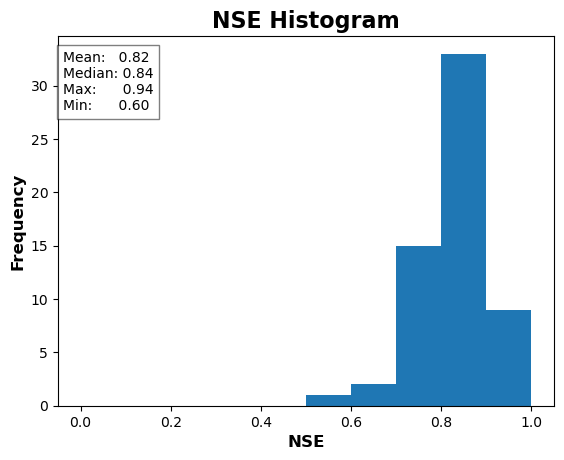

In [20]:
# Plot histogram of NSE

# Export NSE of different basins to a txt
aux= [list(selected_basins_hybrid), list(np.round(loss_testing.flatten().cpu().detach().numpy(),2))]
df_NSE= pd.DataFrame(list(zip(*aux)), columns=['basin_id', 'NSE_LSTM'])
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(save_folder+'/NSE_LSTM.txt', index=True, header=True)

# Calculate NSE statistics
NSE_array = np.asarray(loss_testing.flatten().cpu().detach().numpy())
NSE_mean = np.mean(NSE_array)
NSE_median = np.median(NSE_array)
NSE_max = np.max(NSE_array)
NSE_min = np.min(NSE_array)

# Plot the histogram
plt.hist(NSE_array, bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % NSE_mean:>6}\nMedian: {"%.2f" % NSE_median:>0}\nMax: {"%.2f" % NSE_max:>9}\nMin: {"%.2f" % NSE_min:>9}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_LSTM_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

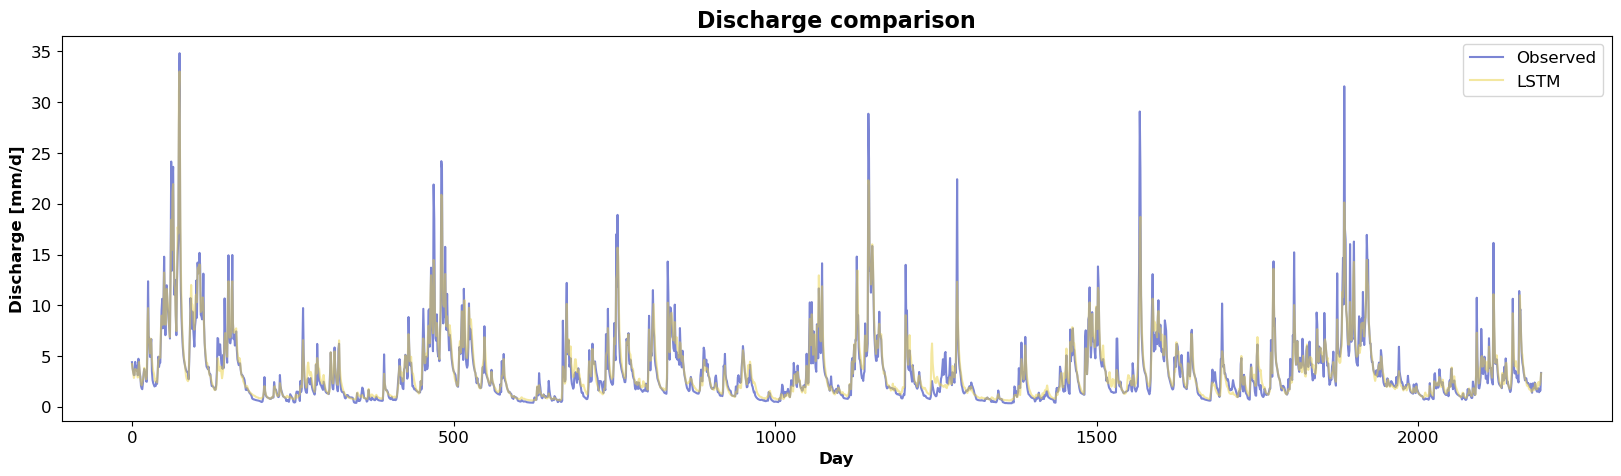

In [22]:
# Plot simulated and observed discharges
basin_to_analyze = 22 # index of the basin. Check the df_NSE variable

sim = sim_q_testing[basin_to_analyze].flatten().cpu().detach().numpy()
obs = obs_q_testing[basin_to_analyze].flatten().cpu().detach().numpy()
plt.plot(obs, label="Observed", color=color_dictionary["Observed"])
plt.plot(sim, label="LSTM", alpha=0.5, color=color_dictionary["LSTM"])
#np.savetxt(save_folder+"/qsim_LSTM.txt", sim)

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)